# Implementación de un modelo GPT

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import tqdm
import re

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Clase anterior

In [2]:
class Tokenizer:

    def __init__(self, corpus_vocabulary):
        self.vocabulary = corpus_vocabulary + ['<BOS>', '<EOS>', '<UNK>', '<PAD>']
        self.vocab_size = len(self.vocabulary)

        self.token_to_id = {token: id for id, token in enumerate(self.vocabulary)}
        self.bos_id = self.token_to_id['<BOS>']
        self.eos_id = self.token_to_id['<EOS>']
        self.unk_id = self.token_to_id['<UNK>']
        self.pad_id = self.token_to_id['<PAD>']

    def encode(self, text):
        seq_tokens = re.findall(r'\d|[^\w\s]|\w+|\s', text)
        seq_ids = [self.token_to_id.get(token, self.unk_id) for token in seq_tokens]
        return seq_ids

    def decode(self, seq_ids):
        seq_tokens = ''.join(self.vocabulary[i] for i in seq_ids)
        return seq_tokens

In [3]:
class TextDataset(Dataset):

    def __init__(self, filename, seq_length):

        with open(filename, 'r', encoding='utf-8') as file:
            corpus = file.read()

        corpus_vocabulary = sorted(set(re.findall(r'\d|[^\w\s]|\w+|\s', corpus)))
        self.tokenizer = Tokenizer(corpus_vocabulary)

        sentences = [sentence.strip() for sentence in corpus.split('\n') if sentence.strip()]
        self.data = [[self.tokenizer.bos_id] + self.tokenizer.encode(sentence) + [self.tokenizer.eos_id] for sentence in sentences]

        self.seq_length = seq_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, n):

        seq_ids = self.data[n]

        if len(seq_ids) > self.seq_length:
            seq_ids = seq_ids[:self.seq_length]
        else:
            seq_ids += [self.tokenizer.pad_id] * (self.seq_length - len(seq_ids))

        return torch.tensor(seq_ids)

In [4]:
seq_length, batch_size = 256, 32

dataset = TextDataset('data.txt', seq_length)
dataloader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)

print(f'Tamaño del dataset: {len(dataset)} secuencias.')
print(f'Tamaño del dataloader: {len(dataloader)} batches.')
print(f'Tamaño del vocabulario: {dataset.tokenizer.vocab_size} tokens.')

Tamaño del dataset: 719 secuencias.
Tamaño del dataloader: 22 batches.
Tamaño del vocabulario: 60198 tokens.


In [5]:
def train_model(model, optimizer, dataloader, epochs, ckpt_filename):

    model.to(DEVICE)
    model.train()

    pad_id = dataloader.dataset.tokenizer.pad_id
    loss_fn = nn.CrossEntropyLoss(ignore_index=pad_id)

    training = {'losses': [], 'model': None}

    try:
        progressbar = tqdm.trange(epochs)
        for epoch in progressbar:

            for seq_batch in dataloader:

                seq_batch = seq_batch.to(DEVICE)  # [batch_size, seq_length].
                x_batch, y_batch = seq_batch[:, :-1], seq_batch[:, 1:]

                logits = model(x_batch)

                batch_size, seq_length, vocab_size = logits.shape
                logits = logits.reshape(batch_size * seq_length, vocab_size)
                y_batch = y_batch.reshape(batch_size * seq_length)

                loss = loss_fn(logits, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                training['losses'].append(loss.item())
                progressbar.set_postfix(loss=loss.item())

    except KeyboardInterrupt:
        print('Entrenamiento interrumpido.')

    training['model'] = model.state_dict()
    torch.save(training, ckpt_filename)

In [6]:
def generate_tokens(model, context, tokenizer, temperature=1, top_k=50, max_tokens=512, repetition_penalty=1):
    model.to(DEVICE)
    model.eval()

    seq_id = [tokenizer.bos_id] + tokenizer.encode(context)
    seq_id = torch.tensor(seq_id, device=DEVICE)

    with torch.no_grad():
        for _ in range(max_tokens):
            logits = model(seq_id.unsqueeze(0))[0, -1, :]

            if temperature == 0:
                next_token = torch.argmax(logits, dim=-1, keepdim=True)
            else:
                logits = logits / temperature

                token_counts = torch.bincount(seq_id, minlength=logits.size(0))
                for token_id, count in enumerate(token_counts):
                    if count > 0:
                        logits[token_id] /= (repetition_penalty ** count)

                top_k_logits, top_k_indices = torch.topk(logits, top_k)
                probs = top_k_logits.softmax(dim=-1)
                next_token = top_k_indices[torch.multinomial(probs, num_samples=1)]

            seq_id = torch.cat((seq_id, next_token), dim=0)

            if next_token in (tokenizer.eos_id, tokenizer.pad_id):
                break

    return tokenizer.decode(seq_id.tolist())

## Arquitectura GPT

In [7]:
class GPTConfig:
    vocab_size = dataset.tokenizer.vocab_size
    context_window = 256
    embedding_dim = 384
    num_layers = 6
    num_heads = 6
    head_dim = 64
    ff_factor = 4
    dropout = 0.1

### Layer normalization

In [8]:
class LayerNorm(nn.Module):

    def __init__(self, emb_dim, epsilon=1e-5):
        super().__init__()

        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        self.epsilon = epsilon

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        x_norm = (x - mean) / torch.sqrt(var + self.epsilon)
        return self.scale * x_norm + self.shift

In [9]:
# Ejemplo de uso:

ln = LayerNorm(GPTConfig.embedding_dim)
x = torch.randn(batch_size, seq_length, GPTConfig.embedding_dim)
y = ln(x)

assert y.shape == (batch_size, seq_length, GPTConfig.embedding_dim)
assert y.mean(dim=-1).allclose(torch.zeros(batch_size, seq_length), atol=1e-5)
assert y.var(dim=-1).allclose(torch.ones(batch_size, seq_length), atol=1e-2)

### Self-attention

In [10]:
class SelfAttentionHead(nn.Module):

    def __init__(self, cfig):
        super().__init__()

        self.query = nn.Linear(cfig.embedding_dim, cfig.head_dim, bias=False)
        self.key = nn.Linear(cfig.embedding_dim, cfig.head_dim, bias=False)
        self.value = nn.Linear(cfig.embedding_dim, cfig.head_dim, bias=False)

        self.dropout = nn.Dropout(cfig.dropout)

    def forward(self, x):

        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        batch_size, seq_length, head_dim = Q.shape
        mask = torch.tril(torch.ones(seq_length, seq_length)).to(x.device)

        attn = Q @ K.transpose(-1, -2) / (head_dim ** 0.5)
        attn = attn.masked_fill(mask == 0, float('-inf'))
        attn = self.dropout(attn.softmax(dim=-1))

        if self.training == False:
            self.attn_matrix = attn.detach()

        return attn @ V

In [11]:
# Ejemplo de uso:

sa = SelfAttentionHead(GPTConfig)
x = torch.randn(batch_size, seq_length, GPTConfig.embedding_dim)
y = sa(x)

assert y.shape == (batch_size, seq_length, GPTConfig.head_dim)

### Atención multicabezal

In [12]:
class MultiHeadSelfAttention(nn.Module):

    def __init__(self, cfig):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttentionHead(cfig) for _ in range(cfig.num_heads)])
        self.projection = nn.Linear(cfig.num_heads * cfig.head_dim, cfig.embedding_dim, bias=False)

    def forward(self, x):
        output = torch.cat([head(x) for head in self.heads], dim=-1)
        output = self.projection(output)
        return output

In [13]:
# Ejemplo de uso:

mhsa = MultiHeadSelfAttention(GPTConfig)
x = torch.randn(batch_size, seq_length, GPTConfig.embedding_dim)
y = mhsa(x)

assert y.shape == (batch_size, seq_length, GPTConfig.embedding_dim)

## Red feed forward

In [14]:
class FeedForward(nn.Module):

    def __init__(self, cfig):
        super().__init__()
        self.fc1 = nn.Linear(cfig.embedding_dim, cfig.ff_factor * cfig.embedding_dim, bias=False)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(cfig.ff_factor * cfig.embedding_dim, cfig.embedding_dim, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [15]:
# Ejemplo de uso:

ff = MultiHeadSelfAttention(GPTConfig)
x = torch.randn(batch_size, seq_length, GPTConfig.embedding_dim)
y = ff(x)

assert y.shape == (batch_size, seq_length, GPTConfig.embedding_dim)

### Bloque transformer

In [16]:
class TransformerBlock(nn.Module):

    def __init__(self, cfig):
        super().__init__()
        self.norm1 = LayerNorm(cfig.embedding_dim)
        self.mhsa = MultiHeadSelfAttention(cfig)
        self.norm2 = LayerNorm(cfig.embedding_dim)
        self.ff = FeedForward(cfig)
        self.dropout = nn.Dropout(cfig.dropout)

    def forward(self, x):
        x = x + self.dropout(self.mhsa(self.norm1(x)))
        x = x + self.dropout(self.ff(self.norm2(x)))
        return x

In [17]:
# Ejemplo de uso:

transformer_blocks = TransformerBlock(GPTConfig)
x = torch.randn(batch_size, seq_length, GPTConfig.embedding_dim)
y = transformer_blocks(x)

assert y.shape == (batch_size, seq_length, GPTConfig.embedding_dim)

## Clase `GPT`

In [18]:
class GPT(nn.Module):

    def __init__(self, cfig):
        super().__init__()

        self.token_embedding = nn.Embedding(cfig.vocab_size, cfig.embedding_dim)
        self.position_embedding = nn.Embedding(cfig.context_window, cfig.embedding_dim)
        self.dropout = nn.Dropout(cfig.dropout)
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(cfig) for _ in range(cfig.num_layers)])
        self.norm_output = LayerNorm(cfig.embedding_dim)
        self.lm_head = nn.Linear(cfig.embedding_dim, cfig.vocab_size, bias=False)

        self.context_window = cfig.context_window

    def forward(self, x):

        x = x[:, -self.context_window:]
        batch_size, seq_length = x.shape

        token_embedding = self.token_embedding(x.long())
        positional_embedding = self.position_embedding(torch.arange(seq_length, device=x.device))

        output = token_embedding + positional_embedding
        output = self.dropout(output)
        output = self.transformer_blocks(output)
        output = self.norm_output(output)
        output = self.lm_head(output)
        return output

In [19]:
# Ejemplo de uso:

gpt = GPT(GPTConfig)
x = torch.randint(GPTConfig.vocab_size, size=[batch_size, seq_length])
y = gpt(x)

assert y.shape == (batch_size, seq_length, GPTConfig.vocab_size)

## Entrenamiento y generación

In [20]:
gpt = GPT(GPTConfig)

n_params = sum(param.numel() for param in gpt.parameters()) / 1e6
print(f'Cantidad de parámetros: {n_params:.3} millones.')

Cantidad de parámetros: 57.0 millones.


### Entrenamiento

In [21]:
gpt_optimizer = optim.AdamW(gpt.parameters())
#train_model(gpt, gpt_optimizer, dataloader, epochs=32, ckpt_filename='gpt_training.pt')

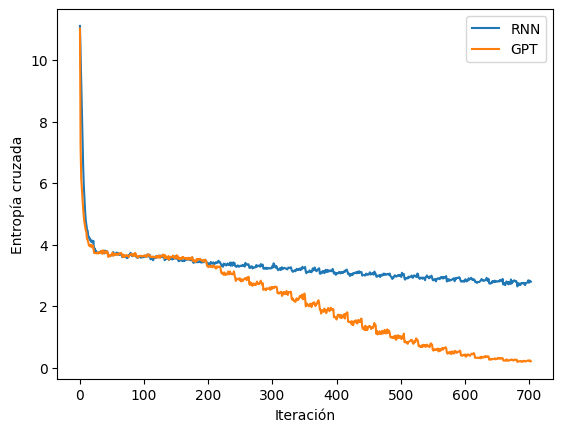

In [22]:
rnn_training = torch.load('rnn_training.pt', DEVICE, weights_only=True)
gpt_training = torch.load('gpt_training.pt', DEVICE, weights_only=True)
gpt.load_state_dict(gpt_training['model'])

plt.plot(rnn_training['losses'], label='RNN')
plt.plot(gpt_training['losses'], label='GPT')
plt.xlabel('Iteración')
plt.ylabel('Entropía cruzada')
plt.legend()
plt.show()

### Generación

In [23]:
context = 'Habia una vez'
new_tokens = generate_tokens(gpt, context, dataset.tokenizer, temperature=0.8, top_k=100, max_tokens=256, repetition_penalty=1)
print(new_tokens)

<BOS>Habia una vez un espejo de mano que cuando se quedaba solo y nadie tirado en el ruido se sentia de un quedaba un hombre piezas dormian abrir y quiza y no gobernador que otros espejos se burlaban de escuchar mucho, cuando que llamado cuando los guardaban en el banco cajon con que lo inexplicable que lo satisfechos, ajenos a la preocupacion del neurotico.<EOS>


### Visualización de las matrices de atención

In [24]:
def show_attn_matrix(text, block):

    tokens = re.findall(r'\d|[^\w\s]|\w+|\s', text)
    token_ids = dataset.tokenizer.encode(text)
    x = torch.tensor(token_ids, device=DEVICE).unsqueeze(0)
    _ = gpt(x)

    heads = gpt.transformer_blocks[block].mhsa.heads
    attn_matrices = [head.attn_matrix[0] for head in heads]

    fig, axes = plt.subplots(2, len(heads) // 2, figsize=(12, 8))
    fig.suptitle(f'Matrices de atención (block={block})')

    for head, ax in enumerate(axes.flatten()):
        ax.imshow(attn_matrices[head])
        ax.set_xticks(ticks=range(len(tokens)), labels=tokens)
        ax.set_yticks(ticks=range(len(tokens)), labels=tokens)
        ax.set_title(f'Head {head + 1}')

    plt.tight_layout()
    plt.show()

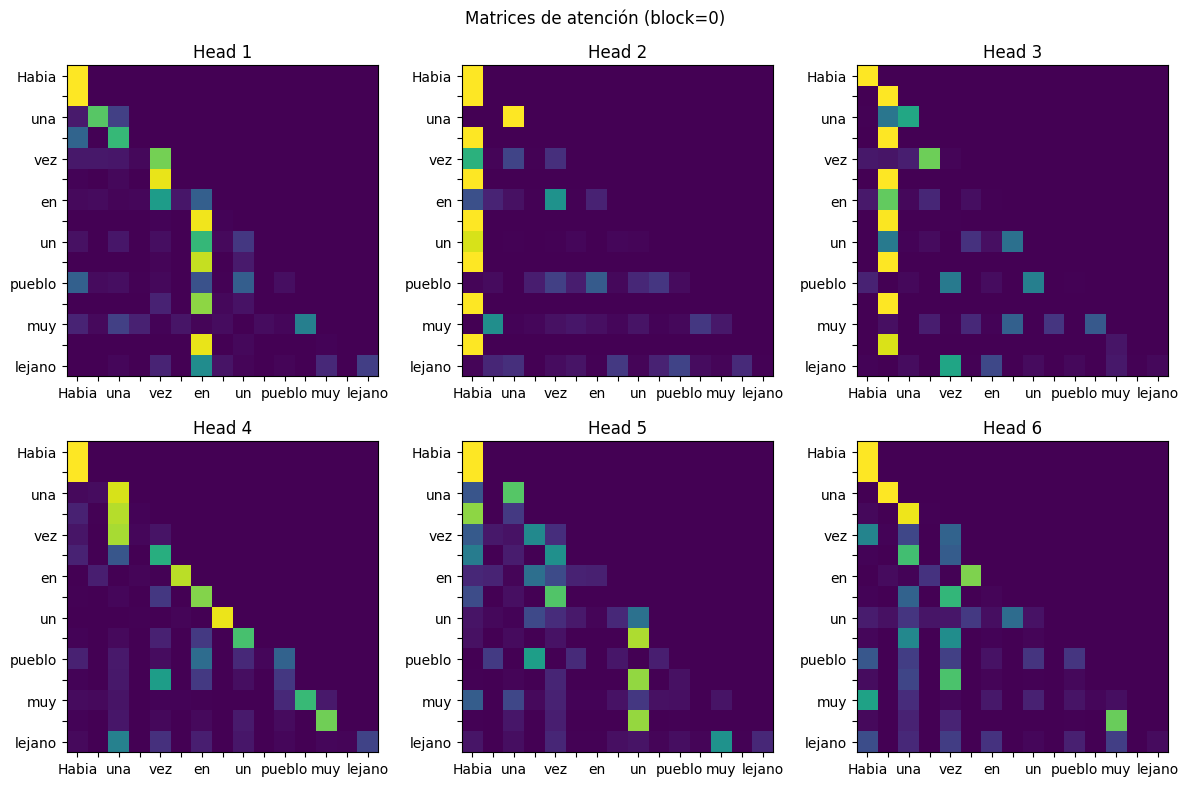

In [25]:
text = 'Habia una vez en un pueblo muy lejano'
show_attn_matrix(text, block=0)